## Baltimore 911 calls
This code looks at the dataset `911_calls_for_service.csv` which contains over 22.4 million 911 calls made in the city of Baltimore. I will clean up the dataset to focus on the relationship between **call time**, **priority**, and **district**. I intend to train a classifier to accurately predict the **priority** of a given call based on the **call time** and **district**.

This dataset records the time, location, priority, and reason for calls to 911 in the city of Baltimore.

## Acknowledgements
Thanks for Kaggle for making this set available. Visit [kaggle.com](https://www.kaggle.com/sohier/baltimore-911-calls/home) if you need publicly available datasets

This dataset was kindly made available by the City of Baltimore. They update the data daily; you can find the original version [here](https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('911_calls_for_service.csv')

# print the size or number of rows and show the first 10 rows
print(df.size)
df.head(10)

22399312


,Unnamed: 0,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,0,2015-07-13 10:41:00,Medium,CD,SEE TEXT,P151941002,0 N CALVERT ST,"(39.2899299,-76.6123462)"
1,1,2015-07-13 10:47:00,Medium,CD,911/NO VOICE,P151941003,600 E FAYETTE ST,"(39.2906737,-76.6071600)"
2,2,2015-07-13 10:42:00,Medium,CD,911/NO VOICE,P151941004,200 E BALTIMORE ST,"(39.2898910,-76.6120720)"
3,3,2015-07-13 10:45:00,Low,CD,PRKG COMPLAINT,P151941005,800 PARK AV,"(39.2985163,-76.6184754)"
4,4,2015-07-13 10:46:00,Medium,SW,AUTO THEFT,P151941006,3500 CLIFTON AV,"(39.3112130,-76.6763150)"
5,5,2015-07-13 10:47:00,Medium,ND,FAMILY DISTURB,P151941007,2700 N CALVERT ST,"(39.3208510,-76.6147390)"
6,6,2015-07-13 10:46:00,High,WD,SILENT ALARM,P151941008,2100 W NORTH AV,"(39.3097096,-76.6513109)"
7,7,2015-07-13 10:49:00,Low,SW,AUTO ACCIDENT,P151941010,3100 WILKENS AV,"(39.2756929,-76.6664179)"
8,8,2015-07-13 10:48:00,Medium,NE,FAMILY DISTURB,P151941011,4800 GILRAY DR,"(39.3483090,-76.5768440)"
9,9,2015-07-13 10:49:00,Medium,ND,NARCOTICSOutside,P151941012,W GARRISON AV/PIMLICO RD,"(39.349653,-76.669145)"


Drop the columns unnecessary for our analysis. 

In [2]:
df = df.drop(columns = ['Unnamed: 0', 'description', 'callNumber', 'incidentLocation', 'location'])
df.head(10)

,callDateTime,priority,district
0,2015-07-13 10:41:00,Medium,CD
1,2015-07-13 10:47:00,Medium,CD
2,2015-07-13 10:42:00,Medium,CD
3,2015-07-13 10:45:00,Low,CD
4,2015-07-13 10:46:00,Medium,SW
5,2015-07-13 10:47:00,Medium,ND
6,2015-07-13 10:46:00,High,WD
7,2015-07-13 10:49:00,Low,SW
8,2015-07-13 10:48:00,Medium,NE
9,2015-07-13 10:49:00,Medium,ND


Detect and remove missing values

In [3]:
# check for missing values
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df.shape[0]
print(f'{missing_values *100} %')

priority    0.237686
dtype: float64 %


In [4]:
# find the mode of this dataset
print(df['priority'].mode())

0    Medium
dtype: object


In [5]:
# replace missing values with the mode
df['priority'] = df['priority'].fillna('Medium')

In [6]:
# check again for missing values
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df.shape[0]
print(f'{missing_values *100} %')

Series([], dtype: float64) %


This is a bit sophisticated, the idea is to strip the data from the `callDateTime` and that helps finding the relationship between the call time and priority

In [7]:
df['callDateTime'] = pd.to_datetime(df['callDateTime'])
df['callDateTime'] = [str(d.time()) for d in df['callDateTime']]

Here I split the dataset into different timeframes, I chose to split it up to 3 hour intervals. The number of intervals is really arbitrary. However, the higher the number of intervals, the more accurate the prediction is.

In [8]:
from datetime import datetime

def inrange(t1, time, t2):
    form = "%H:%M"
    t1 = datetime.strptime(t1, form)
    t2 = datetime.strptime(t2, form)
    time = datetime.strptime(time[:-3], form)
    
    return t1 < time < t2

def timeofday(time):
    if inrange('4:00', time, '6:59'):
        return 0
    elif inrange('7:00', time, '9:59'):
        return 1
    elif inrange('10:00', time, '12:59'):
        return 2
    elif inrange('13:00', time, '15:59'):
        return 3
    elif inrange('16:00', time, '18:59'):
        return 4
    elif inrange('19:00', time, '21:59'):
        return 5
    elif inrange('22:00', time, '00:59'):
        return 6
    else:
        return 7

df['callDateTime'] = df['callDateTime'].apply(timeofday)

np.unique(df['callDateTime'])

array([0, 1, 2, 3, 4, 5, 7], dtype=int64)

Moving on to priority. This time I will just use the `LabelEncoder` function from sklearn's preprocessing library.

In [9]:
priority = np.unique(df['priority'])
priority

array(['Emergency', 'High', 'Low', 'Medium', 'Non-Emergency',
       'Out of Service'], dtype=object)

In [10]:
from sklearn.preprocessing import LabelEncoder

df['priority'] = LabelEncoder().fit_transform(df['priority'])
# call LabelEncoder().inverse_transform(array) to recall values 

df.head()

,callDateTime,priority,district
0,2,3,CD
1,2,3,CD
2,2,3,CD
3,2,2,CD
4,2,3,SW


In [11]:
df['district'] = LabelEncoder().fit_transform(df['district'])

df.head(10)

,callDateTime,priority,district
0,2,3,0
1,2,3,0
2,2,3,0
3,2,2,0
4,2,3,15
5,2,3,9
6,2,1,17
7,2,2,15
8,2,3,10
9,2,3,9


### Statistics
Here I explore the nature of this dataset. This will help us understand the parameters we need for our probability analysis.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


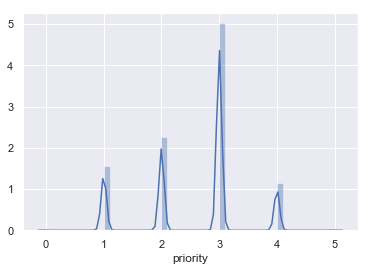

In [12]:
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
x = df['priority']
sns.distplot(x)

The majority of calls closely resemble a normal distribution with the mode being Medium as we predicted earlier

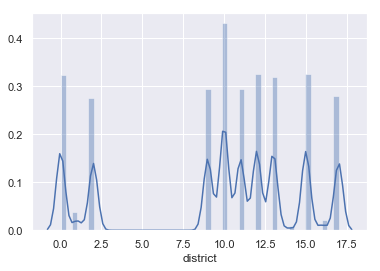

In [13]:
sns.set()
sns.distplot(df['district'])

Seems like some districts are more likely to call 911 than others. Maybe this is due to the fact of how districts are geographically defined.

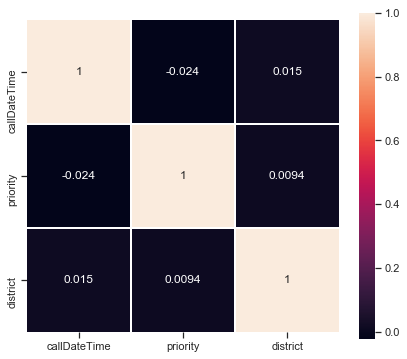

In [14]:
sns.set(style='ticks', color_codes=True)
plt.figure(figsize=(7, 6))
sns.heatmap(df.astype(float).corr(), 
            linewidths=0.2, 
            square=True, 
            linecolor='white', 
            annot=True)
plt.show()

## Machine Learning (prediction)

First, we need to display our call datetime slightly differently. To start, we need to switch them back to strings since we need the strings to get dummy matrix.

#### Dummy Matrix

The Pandas `get_dummies` converts the matrix of ones and zeros. This will be more useful since our classifiers will treat the inputs as numbers instead of integers

$\left \{ x_{i} \; | \; x_{i} \in \mathbb{Z} \;:\; x_{i} \in [0, 1] \right \}$

$$\begin{pmatrix}\text{Medium}\\ \text{High}\\ \text{Low}\\ \vdots  \end{pmatrix}=\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1n} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{d1} & x_{d2} & x_{d3} & \dots  & x_{dn}
\end{bmatrix} \begin{pmatrix}\text{High}\\ \text{Medium}\\ \text{Low}\\ \vdots  \end{pmatrix}$$

In [15]:
df['callDateTime'] = [str(d) for d in df['callDateTime']]
df['district'] = [str(d) for d in df['district']]

df = pd.get_dummies(df)

df.head()

,priority,callDateTime_0,callDateTime_1,callDateTime_2,callDateTime_3,callDateTime_4,callDateTime_5,callDateTime_7,district_0,district_1,...,district_16,district_17,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,3,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This part will split the data into features and classifiers. The classifier is the first row (**priority**). The features are all other rows.

In [51]:
X = df[df.columns[2:]].values
y = df[df.columns[1]].values

Split the data into training and testing sets.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [53]:
from sklearn import tree

decTree = tree.DecisionTreeClassifier()

decTree = decTree.fit(X_train, y_train)

In [54]:
from sklearn.metrics import accuracy_score

decTree_score = accuracy_score(y_test, decTree.predict(X_test))

print('Accuracy using Decision Tree Classifier is nearly ' + f'{decTree_score *100} %')

Accuracy using Decision Tree Classifier is nearly 100.0 %


In [55]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression().fit(X_train, y_train)

logReg_score = accuracy_score(y_test, logReg.predict(X_test))

print('Accuracy using Logistic Regression is nearly ' + f'{logReg_score *100} %')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy using Logistic Regression is nearly 100.0 %


This is outstanding! Using only 10% of the data, we were able to predict priority of a given call using location and time of call. Notice that the `accuracy_score` by default rounds the numbers up. In reality, this might be around 99.9991% but it is still pretty acccurate.